## Watson Text to Speech Analysis

This notebook demonstrates how to convert text data into speech using Watson Speech libraries.
### What you'll learn in this notebook
Watson Text to Speech offers so-called parameters for various text-to-speech synthesis for an entire request rate_percentage, pitch_percentage, and spell_out_mode. By using these parameters we can modify the output of audio. This Notebook Shows :

### Speech Synthesis:
Watson Text to Speech service installed at Kube Cluster. There we are using an HTTP Interface to recognize this service.
This service use speech-synthesis capabilities to synthesize text into natural-sounding speech in a variety of languages, dialects, and voices. This service also provides various parameters which can modify speech synthesis characteristics.

1. **Language  & Model Support:**
The service supports Speech Synthesis for the many languages & models for the languages it supports. As in this notebook we are processing only <strong>English Text</strong> data. So we are using <strong>en-US_AllisonV3Voice </strong> model here.

1. **Audio Format:** 
The service offers neural voices to synthesize text-to-speech in many languages and dialects:.<strong>(mp3,wav,ogg,pcm etc.)</strong>

1. **Speech Synthesis Characteristics**
    1. **Rate Percentage:**
     Using rate_percentage query parameter to modify the rate of the synthesized speech for a voice. The parameter value can be an integer that represents the percentage change from the voice's default:
    Example :
         1. Specify a signed negative integer to reduce the speaking rate by that percentage. For example, -10 reduces the rate by ten percent.
         1. Specify an unsigned or signed positive integer to increase the speaking rate by that percentage. For example, 10 and +10 increase the rate by ten percent.
         1. Specify 0 or omit the parameter to get the default speaking rate for the voice.
    1. **Pitch Percentage**:
     Using pitch_percentagequery parameter to modify the pitch of the synthesized speech for a voice. Each voice has a default, baseline pitch that reflects the intended tone of that voice. The parameter accepts an integer that represents the percentage change from the voice's default:
   Example: 
        1. Specify a signed negative integer to reduce the pitch by that percentage. For example, -10 reduces the pitch by ten percent.
        1. Specify an unsigned or signed positive integer to increase the pitch by that percentage. For example, 10 and +10 increase the pitch by ten percent.
        1. Specify 0 or omit the parameter to get the default pitch for the voice.

               


## Table of Contents


1.  [Before you start](#beforeYouStart)
1.	[Data Loading](#loadData)
1.  [Data Processing & EDA](#EDA)
1.  [Text To Speech Synthesis](#TTS)
1.  [Modifying speech synthesis characteristics](#MTTS)
     1. [Rate Percentage](#MTTS)
     1. [Pitch Percentage](#MTTS1)
1.  [Summary](#summary)

<a id="beforeYouStart"></a>
### 1. Before you start

<div class="alert alert-block alert-warning">
You already have a IBM Account and TTS Runtime service running in a k8/OpenShift cluster. 
</div>  

Note : To use TTS Runtime kube cluster service you can follow the steps from the Tutorial. 

<span style="color:blueviolet">Begin by importing and initializing some helper libs that are used throughout the notebook.</span>

In [1]:
from matplotlib import pyplot as plt
import IPython.display as ipd
import librosa
import pandas as pd
%matplotlib inline
import soundfile as sf

<a id="loadData"></a>
## 2. Data Loading (Text Data)

<div class="alert alert-block alert-info">
<b>Tip:</b> If you want to carry out Text data on any other dataset, you should first upload the dataset into the project and then update the name of the file in the next cell</div>

<span style="color:blueviolet"><strong>Step 2.1</strong> We load the consumer complaints into a DataFrame.</span>

<span style="color:blue">This sample data set contains 50 consumer complaints transcripts with the date.</span>

In [2]:
consumer_df = pd.read_csv('consumer_data.csv')

In [4]:
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400
consumer_df.head()

,Unnamed: 0,Date received,Consumer complaint narrative
0,14,2022-03-07,"I have been disputing fraud accounts on my credit report since XX/XX/XXXX. I keep sending multiple sets of letters to the bureaus so the excuse of "" we didn't get it '' doesn't happen. Furthermore, each letter is signed and attached with an FTC and Identity Theft affidavit, yet the bureaus are still not taking any actions. The accounts are not showing in dispute nor are they removed from my re..."
1,16,2022-03-21,Beginning in XXXX of XXXX I reached out to Midland Credit to request information pertaining to a debt showing on my credit report that I did not recognize. I requested information and validation of the debt and did not receive any information or correspondents. I sent multiple letters and did not receive any of the requested information. \n\nIn XXXX of XXXX I started receiving court paper and ...
2,20,2022-03-06,On XX/XX/XXXX I was called by TD Bank ( XXXX ) XXXX which is an accurate phone number for the bank. I was told that there was suspected fraud on my account and they needed to confirm some of my transactions on my checking account. He asked for the last 4 of my SS # which I provided as this is commonly requested to verify my identity. He then proceeded to recite transactions in my account. Some...
3,21,2022-03-07,"Equifax Information Services, LLC is in violation of the Fair Credit Reporting Act for refusing to have reasonable procedures in place to ensure maximum possible accuracy. I know my rights and I am being damaged by Equifax Information Services , LLC. \n1. Last week, I submitted CFPB Complaint # XXXX for the same reason I am submitting this one. \n2. Equifax Information Services, LLC chose to c..."
4,25,2022-05-29,"In accordance with the Fair Credit Reporting Act 15 U.S.C 1681 & Fair Debt Collection Practices Act 15 U.S.C XXXX CKS PRIME INVESTMENTS, has violated my rights. \n( XXXX XXXX XXXX XXXX XXXX XXXX ) HAS VIOLATED MY RIGHTS. \n\n15 U.S.C XXXX section 602 A. States I have the right to privacy.\n\n15 U.S.C XXXX section 604 A. Section 2 : It also states a consumer reporting agency can not furnish ..."


<a id="EDA"></a>
### 3. Data Processing & EDA
#### 3.1 Text Pre-Processing
 Speech Synthesis services accepts the data in format of JSON. There are so many escape characters that have came into text which is not valid for JSON string .So replacing those char from the text.


In [6]:
# Pre-processing steps for document level only remove escape char & Patterns which is find they are comman
def clean(doc):
    stop_free = " ".join([word.replace('X','').replace('/','') for word in doc.split()])
    return stop_free

In [7]:
consumer_data_list = consumer_df['Consumer complaint narrative']

<span style="color:blueviolet"><strong>Step 3.1</strong> Apply all pre-processing steps to remove escape char from text.</span>

In [9]:
consumer_clean_list = [clean(doc) for doc in consumer_data_list] 

<a id="TTS"></a>
### 4.  Text To Speech Synthesis


<span style="color:blueviolet"> <strong>Step 4.1 </strong>Using Kubernetes Watson Text To Speech service's POST /v1/synthesize method to request a synthesize.</span>

In [10]:
#speech url , here port defines on basis of kubernetes port forword 
text_to_speech_url ='http://localhost:1080/text-to-speech/api/v1/synthesize'

<span style="color:blueviolet"> <strong>Step 4.2 </strong>Setting up parameters to access Speech Synthesis service to get audio from the text. This service is accepting content-type as JSON and it can be accept any type of format output of audio file. </span>

In [11]:
import requests
#speech url , here port defines on basis of kubernetes port forword 
text_to_speech_url ='http://localhost:1080/text-to-speech/api/v1/synthesize'
# Setting up the headers for post request to service 
headers = {"Content-Type": "application/json","Accept":"audio/wav"}
#Setting up params
params ={'output':'output_text.wav'}

<span style="color:blueviolet"> <strong>Step 4.3 </strong>creating a data in JSON format to send as a parameter to the service </span>

In [12]:
data ='{"text":"Text to Speech service provides APIs that use IBM\'s speech-synthesis capabilities to synthesize text into natural-sounding speech in a variety of languages, dialects, and voices"}'

<span style="color:blueviolet"> <strong>Step 4.3 </strong> Created method to run the TTS service </span>

In [20]:
# method to get the Voice data from the text service 
def getSpeechFromText(headers,params,data,file_name):
    request =requests.post(text_to_speech_url,headers=headers,params =params,data=data)
    print(request.status_code)
    if request.status_code != 200:
        print("TTS Service status:", request.text)
        print("Creating file ---",file_name)
    with open(file_name, mode='bx') as f:
        f.write(request.content)
    

<span style="color:blueviolet"> <strong>Step 4.4 </strong> Providing file_name to save the audio file</span>

In [21]:
file_name = 'consumer_output1.wav'
result = getSpeechFromText(headers,params,data,file_name)

200


<span style="color:blueviolet"><strong>Step 4.5</strong> This method use to  play audio files into the Notebook </span>

In [22]:
def print_plot_play(fileName, text=''):
    x, Fs = librosa.load(fileName, sr=None)
    print('%s Fs = %d, x.shape = %s, x.dtype = %s' % (text, Fs, x.shape, x.dtype))
    plt.figure(figsize=(10, 5))
    plt.plot(x, color='blue')
    plt.xlim([0, x.shape[0]])
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(data=x, rate=Fs))

 Fs = 22050, x.shape = (247280,), x.dtype = float32


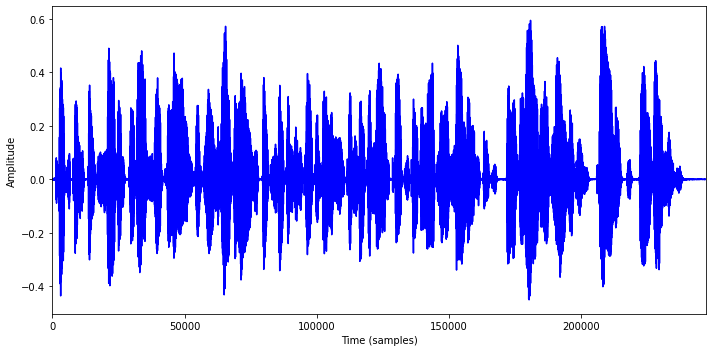

In [24]:
print_plot_play(file_name)

<span style="color:blue">Here we can play the outpot of Speech synthesis and check the quality </span>

<a id="MTTS"></a>
### 5.  Modifying Speech Synthesis Characteristics : 
Text to Speech service includes query parameters that you can use to globally modify the characteristics of speech synthesis for an entire request: 

#### 5.1 Rate Percentage :
 Using rate_percentage query parameter to modify the rate of the synthesized speech for a voice.


<span style="color:blueviolet"><strong>Step 5.1</strong> Here rate_percentage can be negative & psotive to show the voice fast & reduce with the normal rate of speaking.</span>

In [30]:
params ={'voice':'en-US_AllisonV3Voice','rate_percentage':-5}
file_name ="text_to_speeh_rate_out.wav"

200
 Fs = 22050, x.shape = (257400,), x.dtype = float32


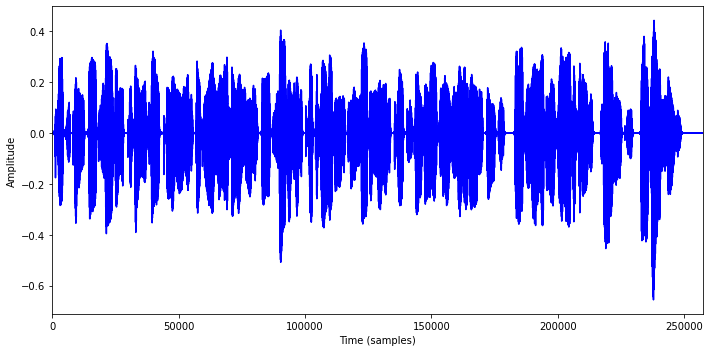

In [31]:
result = getSpeechFromText(headers,params,data,file_name)
print_plot_play(file_name)

200
 Fs = 22050, x.shape = (257400,), x.dtype = float32


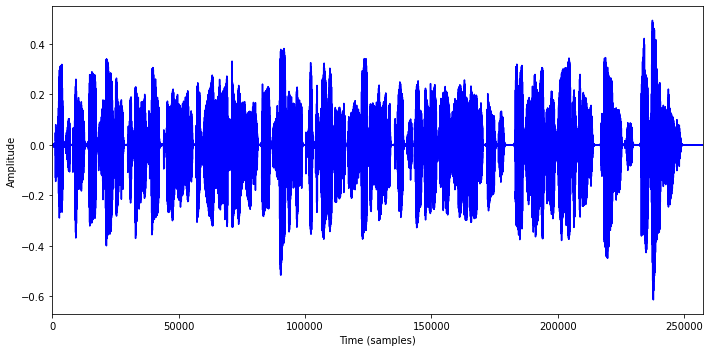

In [34]:
# Here Using this parameter with postive rate to increase speeking rate
params ={'voice':'en-US_AllisonV3Voice','rate_percentage':40}
file_name ="text_to_speeh_rate_out1.wav"
result = getSpeechFromText(headers,params,data,file_name)
print_plot_play(file_name)

<span style="color:blue">Here we are able to see how the speaking rate is differ in by using the rate_percentage parameter</span>

<a id ="MTTS1"></a>
#### 5.2  Pitch Percentage :
 Using pitch_percentage query parameter to modify the  pitch, or tone, of the speech that the service synthesizes.


<span style="color:blueviolet"><strong>Step 5.2</strong> Here pitch_percentage can be negative & psotive to show the voice tone or pitch modify with the normal pitch of voice..</span>

200
 Fs = 22050, x.shape = (257400,), x.dtype = float32


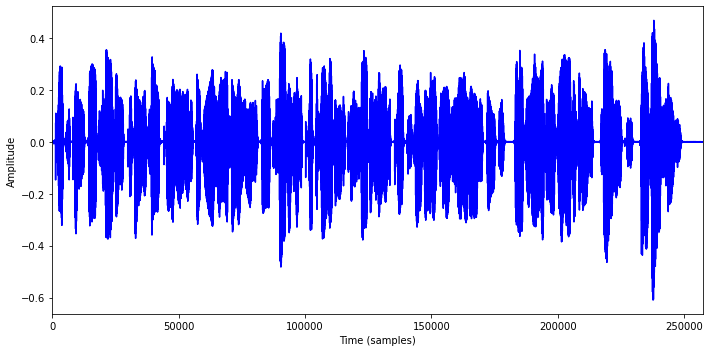

In [35]:
params ={'voice':'en-US_AllisonV3Voice','pitch_percentage':-10}
file_name ="text_to_speeh_pitch_out.wav"
result = getSpeechFromText(headers,params,data,file_name)
print_plot_play(file_name)

200
 Fs = 22050, x.shape = (257400,), x.dtype = float32


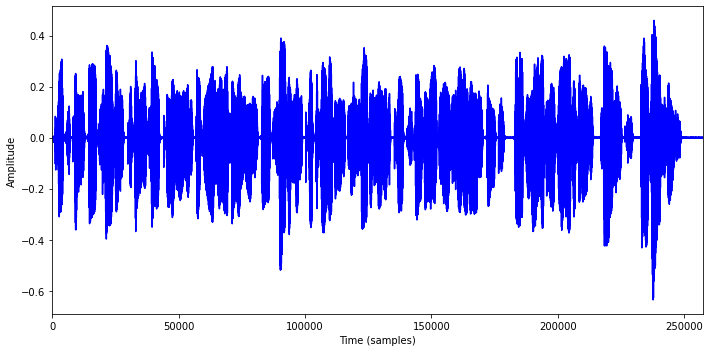

In [36]:
params ={'voice':'en-US_AllisonV3Voice','pitch_percentage':20}
file_name ="text_to_speeh_pitch_out1.wav"
result = getSpeechFromText(headers,params,data,file_name)
print_plot_play(file_name)

<span style="color:blue">Here we are able to see how the voice pitch is differ by using the pitch_percentage parameter</span>

<a id="summary"></a>
## 4. Summary

<span style="color:blue">This notebook shows you how to use the Watson Text to speech library:</span>

Please note that this content is made available by IBM Build Lab to foster Embedded AI technology adoption. The content may include systems & methods pending patent with USPTO and protected under US Patent Laws. For redistribution of this content, IBM will use release process. For any questions please log an issue in the [GitHub](https://github.com/ibm-build-labs/Watson-NLP). 

Developed by IBM Build Lab 

Copyright - 2022 IBM Corporation 